<a href="https://colab.research.google.com/github/kimimumemo/nanem/blob/main/Nanem_AllFolder_HSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This model is not used because:
1. Soil boundaries, in this model we named it as lower_th and upper_th which are the youngest to the oldest don't work the way it should. It is because, in one soil classification, there are so many colors that are not included in the palette. It might because of the composition of the color component in every pixel. So, the thresholding results don't make any impact on our model, maybe worsen our model.

2. We didn't get the right source to replace the black background when HSV and Thresholding were done. This is very influential on one of our classification categories, namely Humus/Black Soil whose color is indeed green.

In [1]:
!pip install -U tensorflow-addons
!pip install -q keras
!pip install split-folders
!pip install tensorflow-gpu

     |████████████████████████████████| 686kB 9.1MB/s 
     |████████████████████████████████| 454.3MB 36kB/s 


In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
import cv2 as cv2
import itertools
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import tensorflow as tf
import tensorflow_hub as hub
import time
import tensorflow_addons as tfa
import uuid
import math

from glob import glob
from IPython.display import clear_output
from keras.utils.np_utils import to_categorical
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
module_selection = ("mobilenet_v2_100_224", 224)
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1".format(handle_base)
IMAGE_SIZE = (224, 224)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

Using https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1 with input size (224, 224)


In [18]:
BASE_PATH = '/content/drive/MyDrive/download_baru_4-224'
OUTPUT_PATH = '/content/drive/MyDrive/download_baru_4_hsv'
IMG_SHAPE = (224,224,3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

In [23]:
# To know how many picture in the datasets

num_files = 0

for folder in os.listdir(BASE_PATH):
  files = os.listdir(os.path.join(BASE_PATH, folder))
  # Calculate num files for image every folder
  print("{} folder has {} pictures".format(folder, len(files)))
  num_files += len(files)
print("\nThere are {} pictures in total".format(num_files))

Latosol folder has 398 pictures
Alluvial folder has 354 pictures
Humus folder has 335 pictures
Clay folder has 334 pictures

There are 1421 pictures in total


In [25]:
from IPython.display import clear_output

# Simple progressBar to monitor progress :D
# Credits: https://www.mikulskibartosz.name/how-to-display-a-progress-bar-in-jupyter-notebook/

def updateProgressBar(progress, bar_length = 50):
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    # Clear current cell output 
    clear_output(wait = True)
    # Print progress!
    print("Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100))

We are using Munsell Soil Chart 

Credits to 

https://digdays.org/wp-content/uploads/2015/10/Munsell-Soil-Color-Description-Terms1-1.pdf

In [6]:
base_model.trainable = False

In [7]:
#Munsell name MAGHEMITE 2.5YR 3/4
rgb_alluvial = np.uint8([[[83,11,14]]])  # 3d array just because this is what cvtColor expects...
hsv_alluvial = cv2.cvtColor(rgb_alluvial, cv2.COLOR_RGB2HSV)[0, 0, :]

In [8]:
#Munsell name HUMUS 10YR 3/1
rgb_black = np.uint8([[[42, 52, 50]]])  # 3d array just because this is what cvtColor expects...
hsv_black = cv2.cvtColor(rgb_black, cv2.COLOR_RGB2HSV)[0, 0, :]

In [9]:
#Munsell N 6/0
rgb_clay = np.uint8([[[128,132,133]]])  # 3d array just because this is what cvtColor expects...
hsv_clay = cv2.cvtColor(rgb_clay, cv2.COLOR_RGB2HSV)[0, 0, :]

In [11]:
#Munsell 10R 3/6
rgb_red = np.uint8([[[96,15,14]]])  # 3d array just because this is what cvtColor expects...
hsv_red = cv2.cvtColor(rgb_red, cv2.COLOR_RGB2HSV)[0, 0, :]

In [26]:
# Check output location
if os.path.isdir(OUTPUT_PATH) == False:
    os.mkdir(OUTPUT_PATH)

num_files = 0
cnt = 0

for folder in os.listdir(BASE_PATH):
  files = os.listdir(os.path.join(BASE_PATH, folder))
   # Calculate num files for progress
  num_files += len(files)
  # Check output label folder exists
  if os.path.exists(os.path.join(OUTPUT_PATH, folder)) == False:
    os.mkdir(os.path.join(OUTPUT_PATH, folder))
    print('folder output not found, create new!')

# Iterate all image location
for folder in os.listdir(BASE_PATH):
  folder_path = os.path.join(BASE_PATH, folder)
  if folder == 'Alluvial':
    #Munsell 2.5YR 2/3
    lower_th = hsv_alluvial-np.array([46, 1, 8])
    #Munsell 2.5YR 3/6
    upper_th = hsv_alluvial+np.array([97, 20, 11])
  
  elif folder == 'Black':
    #Munsell 10BG 2/1
    lower_th = hsv_black-np.array([42, 49, 49])
    #Munsell 5BG 5/1
    upper_th = hsv_black+np.array([114, 126, 124])

  elif folder == 'Clay':
    #Munsell N 4/0
    lower_th = hsv_black-np.array([60, 65, 73])
    #Munsell N 8/0
    upper_th = hsv_black+np.array([195, 194, 189])
    

  elif folder == 'Red':
    #Munsell 10R 3/2
    lower_th = hsv_red-np.array([61,25,27])
    #Munsell 10R 4/6
    upper_th = hsv_red+np.array([116,28,20])

  # Iterate all images at current folder location
  for image in os.listdir(folder_path):
    image_path = os.path.join(BASE_PATH, folder, image)
    filename, ext = os.path.splitext(image_path)
    if os.path.isfile(image_path) == False:
      print('{}, not found, skipping...'.format(image))
      continue
    
    print('Processing image {} ...'.format(image))
    image_read = cv2.imread(image_path)
    image_hsv = cv2.cvtColor(image_read, cv2.COLOR_BGR2HSV)

    # Threshold the HSV image
    mask = cv2.inRange(image_hsv, lower_th, upper_th)
    rgb_res = cv2.bitwise_and(image_read, image_read, mask = mask)

    # Save Image
    output_location = os.path.join(OUTPUT_PATH, folder, image)
    cv2.imwrite(output_location, rgb_res)
    print('Done Processed image {} at {}'.format(image, output_location))

    cnt += 1
    updateProgressBar(cnt / num_files)  

updateProgressBar(1)

Progress: [##################################################] 100.0%


In [30]:
BATCH_SIZE = 32

data_dir = OUTPUT_PATH

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False

if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
  train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 282 images belonging to 4 classes.
Found 1139 images belonging to 4 classes.


In [31]:
model = tf.keras.Sequential([
    # hub.KerasLayer(MODULE_HANDLE, dtype=tf.uint8),
    # hub.KerasLayer(MODULE_HANDLE, trainable=True),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()
# opt = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)
model.compile(loss='categorical_hinge', optimizer='adam', metrics=['accuracy'])
# callbacks from tensor

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62720)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 250884    
Total params: 2,508,868
Trainable params: 2,474,756
Non-trainable params: 34,112
_________________________________________________________________


In [32]:
 do_fine_tuning = False

In [34]:
start = time.time()

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

end = time.time()
print("Total train time: ",(end-start)/60," mins")

Epoch 1/5
35/35 [==============================] - 200s 6s/step - loss: 1.0613 - accuracy: 0.4670 - val_loss: 1.1427 - val_accuracy: 0.4297
Epoch 2/5
35/35 [==============================] - 197s 6s/step - loss: 1.0482 - accuracy: 0.4770 - val_loss: 1.1505 - val_accuracy: 0.4258
Epoch 3/5
35/35 [==============================] - 198s 6s/step - loss: 1.0897 - accuracy: 0.4562 - val_loss: 1.1661 - val_accuracy: 0.4180
Epoch 4/5
35/35 [==============================] - 198s 6s/step - loss: 1.0198 - accuracy: 0.4616 - val_loss: 1.5880 - val_accuracy: 0.2070
Epoch 5/5
35/35 [==============================] - 197s 6s/step - loss: 0.7306 - accuracy: 0.5836 - val_loss: 1.5881 - val_accuracy: 0.2070
Total train time:  16.59218627611796  mins


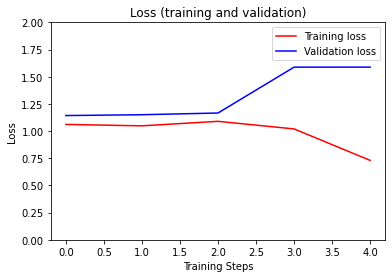

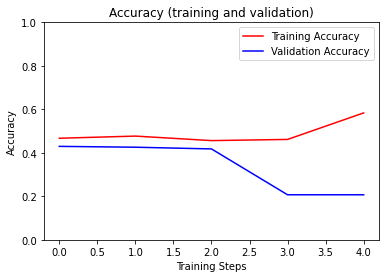

In [35]:
loss = hist['loss']
val_loss = hist['val_loss']
acc = hist["accuracy"]
val_acc = hist["val_accuracy"]
epochs = range(len(val_acc))

plt.figure()
plt.title("Loss (training and validation)")
plt.ylabel("Loss")
plt.xlabel("Training Steps")

plt.ylim([0,2])
plt.plot(loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.legend()

plt.figure()
plt.title("Accuracy (training and validation)")
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")

plt.ylim([0,1])
plt.plot(acc, 'r', label='Training Accuracy')
plt.plot(val_acc, 'b', label='Validation Accuracy')
plt.legend()
plt.show()